<div align="right" style="text-align: right"><i>Peter Norvig<br>2012, 2020, 2021</i></div>

# The Unfinished Game ... of Risk

[Keith Devlin](https://web.stanford.edu/~kdevlin/)'s [book](https://www.amazon.com/Unfinished-Game-Pascal-Fermat-Seventeenth-Century/dp/0465018963) [*The Unfinished Game*](https://wordplay.blogs.nytimes.com/2015/12/14/devlin-unfinished-game/) describes how Fermat and Pascal discovered the rules of probability that guide gambling in games. The question they confronted was: what if a gambling game is interrupted, but one player is in the lead by a certain score. How much of the pot should the leader get?

My friends and I faced a similar question when a game of [*Risk*](https://www.ultraboardgames.com/risk/game-rules.php) ran on too long (as they often do) and we were unable to finish. Player **A** had just cashed in cards and added troops to a single large force that was poised to make a sweeping attack on player **B**, whose territories were arranged in such a way that **A** could attack from one territory to the next without ever having to branch off.  We wrote down the number of **A**'s massed armies, **72**, and the number of armies in **B**'s successive territories: **22, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1.** What is the probability that **A** can capture all these territories?

______

# Terminology

Let's explain some *Risk* rules and terminology:

- A **battle** is when armies from one territory attack an enemy neighboring territory. A roll of dice determines which armies perish:
  - The attacker will roll 3 dice if possible (but no more than the number of armies in the attacking territory minus one).
  - The defender will roll 2 dice if possible (or only one if they have only one army remaining). 
  - The **outcome** of the battle is determined by comparing the highest die from each of the two players, with the defender losing an army if the attacker's die is higher, and the attacker losing an army if tied or lower. Then if both sides rolled at least two dice, we do the same comparison with the second highest die on each side. 
  - When a battle kills off the last defender in a territory, the attackers **occupy** the territory. They must leave behind one army, but can move the rest in.  

- A **campaign** consists of a sequence of battles and occupations. We will consider only a **chain** campaign, in which attackers invade successive enemy territories in order, always moving all their remaining armies into each captured territory, never branching, and never changing strategy based on the result of a battle. The attackers **win** the campaign if they occupy all the territories. The attackers **lose** if there are any remaining defenders and only one remaining attacker, who by rule cannot attack.

With that out of the way, we're ready for some Python implementation.

In [1]:
from collections import Counter
from functools   import lru_cache
import itertools
import matplotlib.pyplot as plt

# Representing the State of a Campaign

I will represent the **state of a campaign** as a tuple where the first element is the number of attacking armies, and subsequent elements are the number of defenders in each successive territory. Thus we can represent the start state of our unfinished campaign as follows:

In [2]:
State = tuple

start = State((72, 22, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1))

I'll define the following functions on states: 
- `A(state)` gives the number of attackers in a state.
- `D(state)` gives the number of defenders in the first territory (or `0` if there are no defenders at all).
- `allD(state)` gives the tuple of numbers of defenders in each territory.
- `update(state, dead)` gives a new state reflecting the number of dead attacking and defending armies spewcified by the two-element tuple  `dead`. If `D(state) == D(dead)` then the attackers have killed off all the defenders in the first territory, and the new state will reflect the fact that the attackers now occupy the territory.

In [3]:
def A(state)    -> int:   "Attackers";       return state[0]
def D(state)    -> int:   "First defenders"; return state[1] if allD(state) else 0
def allD(state) -> tuple: "All defenders";   return state[1:]

def update(state, dead) -> State:
    """Update the state of a campaign to reflect battle deaths."""
    if D(state) == D(dead):
        return State((A(state) - A(dead) - 1, *allD(state)[1:])) # Occupy territory, leaving 1 behind
    else:
        return State((A(state) - A(dead), allD(state)[0] - D(dead), *allD(state)[1:])) # Can't occupy yet

In [4]:
# Tests

assert A(start)  == 72
assert D(start)  == 22 
assert allD(start) == (22, 8, 2, 2, 2, 7, 1, 1, 3, 1, 2, 3, 5, 1)
assert sum(allD(start)) == 60 
assert len(allD(start)) == 14

assert update((10, 2, 5), (0, 2)) == (9, 5)    # 2 defenders dead; occupy the first territory
assert update((10, 2, 5), (1, 1)) == (9, 1, 5) # continue to battle
assert update((10, 2, 5), (2, 0)) == (8, 2, 5) # continue to battle

# Rolling the Dice: Death Counts

First we'll define the function `deaths`, which, given the specific sets of dice rolled by attacker and defender in a battle,  returns a `State` tuple that gives the number of attackers and defenders who perish in the battle:

In [5]:
die  = (1, 2, 3, 4, 5, 6)
Dice = list # a sorted list of die rolls

def deaths(A_dice: Dice, D_dice: Dice) -> State:
    """How many (attacker, defender) armies perish as the result of these dice?"""
    dead = [0, 0]
    for a, d in zip(sorted(A_dice, reverse=True), 
                    sorted(D_dice, reverse=True)):
        dead[a > d] += 1
    return State(dead)

In [6]:
# Tests: the 4 sample dice rolls from www.ultraboardgames.com/risk/game-rules.php

assert deaths((6, 1, 1), (3,))   == (0, 1) # Defender loses one
assert deaths((6, 2, 1), (3, 2)) == (1, 1) # Both lose one
assert deaths((3, 3),    (4, 3)) == (2, 0) # Attacker loses two
assert deaths((6,),      (5, 4)) == (0, 1) # Defender loses one

assert update((10, 2, 5), deaths((6, 2, 1), (3, 2))) == (9, 1, 5)

# Simulation versus Full Probability Distribution

My first approach to the problem was a  [**Monte Carlo simulation**](https://en.wikipedia.org/wiki/Monte_Carlo_method), in which I used random dice rolls to determine the outcome of each battle, and thus the campaign. That was good enough to estimate the probability of winning to within 1%, but it was not good enough to get a completely accurate breakdown of all possible outcomes. 

Therefore I decided to compute the full probability distribution for a campaign. The code becomes a bit more complex, because we have to deal with a collection of possible results for each dice roll, not just a single result. However, I think the precision gained is worth the slight code complexity. 

`Pdist` will be used to represent a probability distribution of the form `{state: probability, ...}`, where the probabilities are normalized so that they are all between 0 and 1, and sum to 1. (I realize that it is suggested that a `Counter`has integer counts, but that is not required, and `Counter` has a nicer API than `dict`, including the fact that it has a default value of 0. So I am not ashamed to inherit from `Counter`.)

In [7]:
class Pdist(Counter): 
    "A Probability distribution."
    def __init__(self, *args):
        Counter.__init__(self, *args)
        total = sum(self.values())
        for x in self:
            self[x] /= total # Normalize
            assert 0.0 <= self[x] <= 1.0

Now for the full probability distribution (over all dice rolls) of deaths in a battle. The input to the function `deaths_pdist` will be a state giving the number of attacking and defending armies for just this one battle. (Thus, the attackers will always be 3, 2, or 1, and the defenders will always be 2 or 1. I define it this way, rather than passing in the full state of the campaign, so that I can **cache** the results and reuse them in subsequent battles.) The return value will be a probability distribution over the number of deaths for attacker and defender. 

In [8]:
@lru_cache()
def deaths_pdist(state) -> Pdist:
    """A probability distribution of deaths in a battle."""
    return Pdist(deaths(A_dice, D_dice)
                 for A_dice in rolls(A(state))
                 for D_dice in rolls(D(state)))

def rolls(n) -> Dice: 
    """All possible rolls of `n` dice."""
    return itertools.product(die, repeat=n)

Below we test all six possible battle dice combinations to make sure they match the odds stated at a [*Risk* data analysis blog](http://datagenetics.com/blog/november22011/):

In [9]:
assert deaths_pdist((1, 1)) == Pdist({(1, 0):   21, (0, 1):   15})
assert deaths_pdist((2, 1)) == Pdist({(1, 0):   91, (0, 1):  125})
assert deaths_pdist((3, 1)) == Pdist({(1, 0):  441, (0, 1):  855})
assert deaths_pdist((1, 2)) == Pdist({(1, 0):  161, (0, 1):   55})
assert deaths_pdist((2, 2)) == Pdist({(2, 0):  581, (1, 1):  420, (0, 2):  295})
assert deaths_pdist((3, 2)) == Pdist({(2, 0): 2275, (1, 1): 2611, (0, 2): 2890})

# Outcomes of a Campaign

A `campaign` is a series of battles. We keep battling until either the attackers no longer have the two armies necessary to enter into a battle, or until there are no defenders left. The function `battle` updates a probability distribution to reflect all possible results of a single battle.

In [10]:
def campaign(start: State) -> Pdist:
    """Probability distribution for all outcomes of a campaign."""
    pdist = Pdist({start: 1})
    while any(map(can_battle, pdist)):
        pdist = battle(pdist)
    return pdist

def battle(pdist) -> Pdist:
    """For every possible campaign state in the Pdist, do one battle, 
    and return an updated `result` Pdist over the outcomes."""
    result = Pdist()
    for state in pdist:
        if not can_battle(state): # State carries through unchanged
            result[state] += pdist[state] 
        else: # Replace state with all outcomes from a battle
            pdead = deaths_pdist((min(3, A(state) - 1), min(2, D(state))))
            for dead in pdead:
                result[update(state, dead)] += pdist[state] * pdead[dead]
    return result

def can_battle(state) -> bool: 
    """The attackers can battle if they have at least 2 armies, and there are defenders."""
    return A(state) >= 2 and allD(state)

def attacker_wins(pdist) -> float: 
    """The probability that the attackers win the campaign in this distribution."""
    return sum(pdist[s] for s in pdist if not allD(s))

Here's a small example campaign: when 4 attackers go against 2 defenders in the first territory and 1 defender in a second territory, the attackers win about 36% of the time (about 15% with 1 attacker remaining in the final territory, and 21% with 2 attackers in the final territory).

In [11]:
campaign((4, 2, 1))

Pdist({(1, 2, 1): 0.21807067805974698,
       (1, 1, 1): 0.12597532213712342,
       (1, 1): 0.294669783648961,
       (1,): 0.14620529335276633,
       (2,): 0.21507892280140226})

In [12]:
attacker_wins(_)

0.3612842161541686

# Finishing the Unfinished Game

What is the probability of  winning the unfinished game?

In [13]:
attacker_wins(campaign(start))

0.8105485936352178

The attackers defeat all the defenders 81% of the time. 

# Analyzing Campaigns

Let's try to see the whole picture. I'll define the **score** of a campaign as the number of attacker armies in the final territory minus the total number of defenders, minus the number of territories that the defenders hold. This score will be positive when the attackers win and negative when they lose. A score cannot be zero (the closest is that there could be one attacker and one defender left, in which case there can be no more attacks, but the score would be -1, because the defenders have one army and one territory). The function `show` plots a histogram of scores:

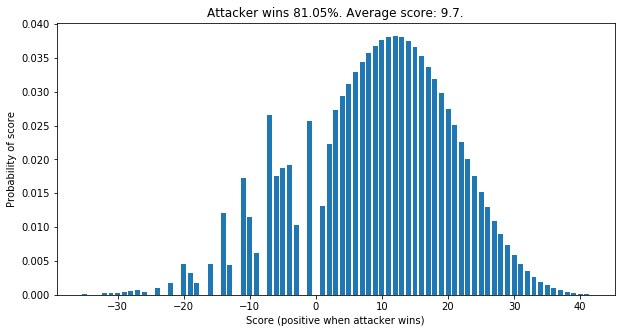

In [14]:
def show(pdist, epsilon=1e-4):
    """Plot and annotate a probability distribution over states."""
    X = [score(s) for s in pdist if pdist[s] > epsilon]
    Y = [pdist[s] for s in pdist if pdist[s] > epsilon]
    avg = sum(score(s) * pdist[s] for s in pdist)
    plt.figure(figsize=(10, 5))
    plt.title(f'Attacker wins {attacker_wins(pdist):.2%}. Average score: {avg:.1f}.')
    plt.xlabel('Score (positive when attacker wins)')
    plt.ylabel('Probability of score')
    plt.bar(X, Y, width=3/4)
    
def score(state): return A(state) - sum(allD(state)) - len(allD(state))
    
show(campaign(start))

In [15]:
S = campaign(start)
Q = Pdist({score(s): S[s] for s in S})
Q[-7]

0.02662110993767859

Interesting! We see that the scores look roughly like a bell-shaped curve on the right side, but with a decidely non-normal pattern on the left side. There are gaps—scores for which the probability is zero—and there are spikes that rise above the normal curve. 

What's causing the gaps? We know that a score can never be 0. And in this campaign, no score can be -2. because a -2 can only be achieved with one attacker and two defenders in one territory; this campaign has only one defender in the final territory. Looking at the plot, we see gaps surrounding groups of bars, where the group sizes, reading left to right, are 1, 1, 3, 1, 2, 3, 5, and 1. Note that these are exactly the number of defenders in the final 8 territories.

What's causing the spikes? To some extent they represent probability mass that has shifted over a place. But the spikes are not quite tall enough to fill in the gaps. And I don't understand the exact shape of each group.

Below is an example where there is no visible gap. The normalish shape is restored, except that there is something going on with odd-versus-even scores. I believe what is happening is that all but the very last few battles will be 3-versus-2 battles, and thus will result in 2 casualties, preserving the parity of the total number of armies. The parity can only be broken in the final battles.

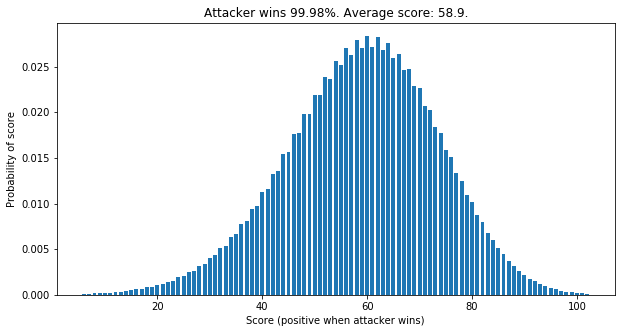

In [16]:
show(campaign((145, 100)))

The odd-even disparity can be lessened by adding a few territories where there will not be 3-versus-2 battles. The result is a very smooth curve, although not normal—it is clearer a bit fatter on the left than the right.

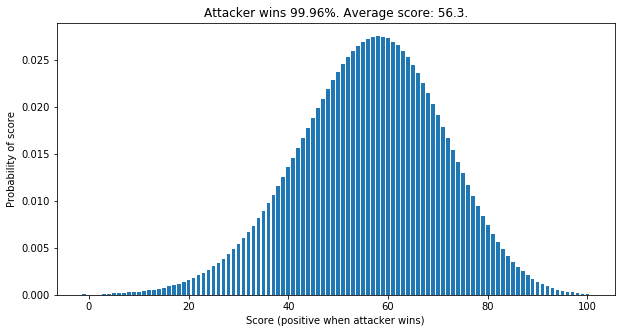

In [17]:
show(campaign((150, 100, 1, 1, 1, 1, 1)))

# Analyzing Single-Territory Attacks

I want to analyze a simpler situation: With *A* attackers and *D* defenders in a single territory, what is the probability the attackers win?  

I will make a chart with the number of defenders varying from 1 to 60, and the number of attackers separated into eight cases (depicted as eight lines), where in each case there are Δ more attackers than defenders:

In [18]:
def chart(defenders=range(1, 61), deltas=(10, 5, 2, 1, 0, -1, -2, -5)):
    """Plot win probability for various numbers of defenders and Δ more attackers."""
    plt.figure(figsize=(10, 5)); plt.grid()
    plt.title('Each line: attackers with Δ more armies than defenders')
    plt.xlabel('Number of Defenders'); plt.ylabel('Win Probability for Attackers')
    for delta in deltas:
        winprobs = [attacker_wins(campaign((max(0, d + delta), d))) for d in defenders]
        plt.plot(defenders, winprobs, '.-', label=f'Δ = {delta}')
    plt.legend()

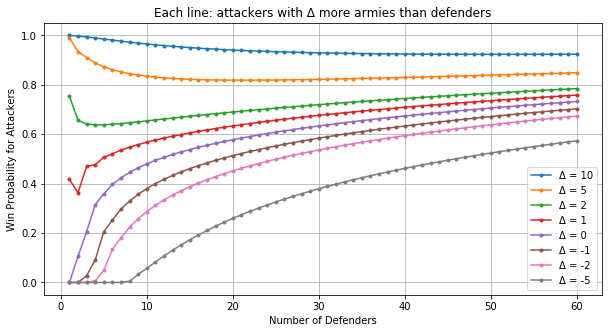

In [19]:
chart()

Note that the purple line (fourth from bottom), where the number of attackers exactly equals the number of defenders, gives a low win probability for a small attacking force, but reaches 50% for 12-on-12, and 73% for 60-on-60. The red line, where the attackers have one more army than the defenders, dips from one to two defenders but is over 50% for a 6-on-5 attack. Similarly, the green line, where the attackers have a surplus of two armies, dips sharply from 75% to 66% as the number of defenders goes from 1 to 2, dips slightly more for 3 and 4 defenders, and then starts to rise. So overall, an attacker does not need a big advantage in armies as long as there are many armies on both sides. Even when the attacker is at a disadvantage in numbers (as in the bottom grey line where the attacker has five fewer armies), the attacker can still have an advantage in win probability; with 55 against 60 the win percentage is about 57%.